In [ ]:
#Imports
%tensorflow_version 1.x

import numpy as np
import pandas as pd
from numpy.linalg import norm
from sklearn.metrics import classification_report, confusion_matrix
from IPython.display import Image, display_png
from gensim.models import word2vec, KeyedVectors
from keras.models import Sequential
from keras.layers import Input, Embedding, Dense, Dropout, Flatten, GlobalAveragePooling1D
from keras.utils import to_categorical, plot_model
from keras.preprocessing.sequence import pad_sequences
from keras.optimizers import RMSprop
import matplotlib.pyplot as plt
plt.style.use('ggplot')

Using TensorFlow backend.


In [ ]:
#downs
!gdown --id 1s-8A8sF7b23Tb9Myoc_3DTl6YXLpL17L  # train data
!gdown --id 1YtAHCzeZUXGZQ9cimdkkUq4lUk3ZH-I_  # evaluate.py
!gdown --id 1EacvwnOHfwa4FiZy2K8mFpFjmpb4Mt-t #test

Downloading...
From: https://drive.google.com/uc?id=1s-8A8sF7b23Tb9Myoc_3DTl6YXLpL17L
To: /content/lab4_train.csv
100% 331k/331k [00:00<00:00, 81.0MB/s]
Downloading...
From: https://drive.google.com/uc?id=1YtAHCzeZUXGZQ9cimdkkUq4lUk3ZH-I_
To: /content/evaluate.py
100% 7.03k/7.03k [00:00<00:00, 10.1MB/s]
Downloading...
From: https://drive.google.com/uc?id=1EacvwnOHfwa4FiZy2K8mFpFjmpb4Mt-t
To: /content/lab4_test.csv
100% 36.2k/36.2k [00:00<00:00, 13.1MB/s]


In [ ]:
!wc -l tokenized.tsv

3155 tokenized.tsv


In [ ]:
sentences = word2vec.LineSentence('tokenized.tsv')
model = word2vec.Word2Vec(sentences, sg=0, size=300, min_count=5, window=5, iter=6)
model.wv.save_word2vec_format('tokenized.bin', binary=True)

/usr/local/lib/python3.6/dist-packages/smart_open/smart_open_lib.py:402: UserWarning: This function is deprecated, use smart_open.open instead. See the migration notes for details: https://github.com/RaRe-Technologies/smart_open/blob/master/README.rst#migrating-to-the-new-open-function
  'See the migration notes for details: %s' % _MIGRATION_NOTES_URL


In [ ]:
#Data to Trains and Devs
data = pd.read_csv('lab4_train.csv') 
train, dev = np.split(data, [int(len(data)*0.8)]) # train:dev = 80:20

In [ ]:
#Tokenizing
import tqdm
import nltk
nltk.download('punkt')
dtitle_list = dev['text'].to_list()
dtkt=[]
for st in tqdm.tqdm(dtitle_list):
  dtkt.append(nltk.word_tokenize(st))
dev['tokenized']=dtkt
ttitle_list = train['text'].to_list()
ttkt=[]
for st in tqdm.tqdm(ttitle_list):
  ttkt.append(nltk.word_tokenize(st))
train['tokenized']=ttkt

  0%|          | 0/2524 [00:00<?, ?it/s]

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


100%|██████████| 2524/2524 [00:00<00:00, 6575.24it/s]


In [ ]:
# create new dataframe(the DEV)
newdf = pd.DataFrame()
# add columns (เอาผลมารวมกัน)
newdf['id'] = dev['id']
newdf['tokenized']= dev['tokenized']
newdf['aspectCategory'] = dev['aspectCategory']  # prediction of aspect
newdf['polarity'] = dev['polarity']  # prediction of polarity

In [ ]:
# add column "length"
train['length'] = train['tokenized'].apply(lambda x:len(x))
dev['length'] = dev['tokenized'].apply(lambda x:len(x))
newdf['length'] = newdf['tokenized'].apply(lambda x:len(x))
newdf

,id,tokenized,aspectCategory,polarity,length
2524,3235,"[The, staff, has, always, been, friendly, with...",service,positive,22
2525,3480,"[Get, it, together, .]",anecdotes/miscellaneous,negative,4
2526,1459,"[The, eggplant, parmesan, is, also, great, ,, ...",food,positive,27
2527,1459,"[The, eggplant, parmesan, is, also, great, ,, ...",anecdotes/miscellaneous,positive,27
2528,1597,"[Quality, ingredients, preparation, all, aroun...",food,positive,14
...,...,...,...,...,...
3151,2853,"[I, would, highly, recommend, this, place, to,...",anecdotes/miscellaneous,positive,12
3152,1163,"[The, service, is, fantastic, .]",service,positive,5
3153,216,"[I, recommend, that, you, try, this, hidden, s...",anecdotes/miscellaneous,positive,14
3154,1109,"[The, garlic, mashed, potatoes, are, hands, do...",food,positive,13


In [ ]:
m_model = KeyedVectors.load_word2vec_format('tokenized.bin', binary=True)
# vocabulary size of pre-trained model
vocab_size = len(m_model.vocab)
print('vocab size:', vocab_size)
# vector dimension
vector_dim = (len(m_model['go']))
print('vector dimension:', vector_dim)
# max length (กำหนดเอง)
max_len = 50

vocab size: 1070
vector dimension: 300


/usr/local/lib/python3.6/dist-packages/smart_open/smart_open_lib.py:402: UserWarning: This function is deprecated, use smart_open.open instead. See the migration notes for details: https://github.com/RaRe-Technologies/smart_open/blob/master/README.rst#migrating-to-the-new-open-function
  'See the migration notes for details: %s' % _MIGRATION_NOTES_URL


In [ ]:
word_to_index = {'PADDING':0}
# make weight matrix of word embedding, vocab size + 1 (for padding)
embedding_matrix = np.zeros((vocab_size+1, vector_dim), dtype="float32")
embedding_matrix[0] = np.zeros(vector_dim)
for i, word in enumerate(m_model.vocab):
    word_to_index[word] = i+1
    embedding_matrix[i+1] = m_model[word] 

In [ ]:
word_to_index['go']

44

In [ ]:
# convert word to index (maximum: first 500 words)
def w2i(tokens):
    return [word_to_index.get(word, 0) for word in tokens[:max_len]]

# apply functions & convert to np.array
input_train = np.array(train['tokenized'].apply(w2i).tolist())
input_dev = np.array(dev['tokenized'].apply(w2i).tolist())

# input : zero padding
train_x = pad_sequences(input_train, max_len, padding='post')
dev_x = pad_sequences(input_dev, max_len, padding='post')

In [ ]:
input_train

array([list([0, 1, 83, 9, 41, 405, 7, 102, 2]),
       list([0, 37, 539, 617, 3, 1, 97, 0, 0, 9, 1, 11, 3, 95, 9, 374, 218, 3, 17, 108, 32, 155, 112, 12, 46, 1, 115, 0, 10, 0, 2]),
       list([0, 37, 539, 617, 3, 1, 97, 0, 0, 9, 1, 11, 3, 95, 9, 374, 218, 3, 17, 108, 32, 155, 112, 12, 46, 1, 115, 0, 10, 0, 2]),
       ...,
       list([0, 28, 322, 30, 0, 0, 30, 273, 441, 124, 4, 0, 88, 192, 7, 44, 70, 12, 68, 21]),
       list([0, 36, 260, 20, 1, 0, 71, 10, 97, 186, 501, 728, 336, 43, 115, 109, 448, 425, 501, 42, 4, 900, 112, 893, 5, 703, 0, 2]),
       list([0, 0, 11, 2])], dtype=object)

In [ ]:
# relabel: scheme 2 (only 3 category)
def relabel(aspn):
    return {'service':0, 'food':1, 'anecdotes/miscellaneous':2, 'ambience':3, 'price':4}[aspn]

# apply functions & convert to np.array
label_train = np.array(train['aspectCategory'].apply(relabel).tolist())
label_dev = np.array(dev['aspectCategory'].apply(relabel).tolist())

# label : one-hot vector
train_y = to_categorical(label_train, num_classes=5)
dev_y = to_categorical(label_dev, num_classes=5)

In [ ]:
# check the shape
print('input train:', train_x.shape)
print('input dev:', dev_x.shape)
print('label train:', train_y.shape)
print('label dev:',dev_y.shape)

input train: (2524, 50)
input dev: (632, 50)
label train: (2524, 5)
label dev: (632, 5)


In [ ]:
# instantiation
model = Sequential()

# add embedding layer
model.add(Embedding(input_dim=vocab_size+1,
                    input_length=max_len,
                    output_dim=vector_dim, 
                    weights=[embedding_matrix], 
                    mask_zero=False,
                    trainable=True))

# average
model.add(GlobalAveragePooling1D())

# add hidden layer
model.add(Dense(100, activation='relu'))
# add output layer
model.add(Dense(5, activation='softmax'))

# compile model
model.compile(optimizer="rmsprop", loss="categorical_crossentropy", metrics=["accuracy"])

model.summary()

Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_5 (Embedding)      (None, 50, 300)           321300    
_________________________________________________________________
global_average_pooling1d_5 ( (None, 300)               0         
_________________________________________________________________
dense_12 (Dense)             (None, 100)               30100     
_________________________________________________________________
dense_13 (Dense)             (None, 5)                 505       
Total params: 351,905
Trainable params: 351,905
Non-trainable params: 0
_________________________________________________________________


In [ ]:
# train
history = model.fit(train_x, train_y, batch_size=128, epochs=100, validation_data=(dev_x, dev_y))

Train on 2524 samples, validate on 632 samples
Epoch 1/100
2524/2524 [==============================] - 1s 297us/step - loss: 1.5197 - acc: 0.3360 - val_loss: 1.5019 - val_acc: 0.3323
Epoch 2/100
2524/2524 [==============================] - 0s 119us/step - loss: 1.4592 - acc: 0.3871 - val_loss: 1.4667 - val_acc: 0.3766
Epoch 3/100
2524/2524 [==============================] - 0s 118us/step - loss: 1.4261 - acc: 0.4188 - val_loss: 1.4481 - val_acc: 0.3940
Epoch 4/100
2524/2524 [==============================] - 0s 116us/step - loss: 1.4000 - acc: 0.4271 - val_loss: 1.4289 - val_acc: 0.4035
Epoch 5/100
2524/2524 [==============================] - 0s 113us/step - loss: 1.3755 - acc: 0.4517 - val_loss: 1.4047 - val_acc: 0.4209
Epoch 6/100
2524/2524 [==============================] - 0s 109us/step - loss: 1.3418 - acc: 0.4770 - val_loss: 1.3739 - val_acc: 0.4415
Epoch 7/100
2524/2524 [==============================] - 0s 112us/step - loss: 1.3027 - acc: 0.5071 - val_loss: 1.3612 - val_acc: 0

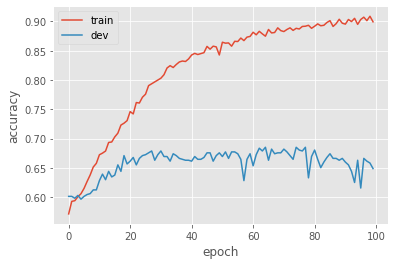

In [ ]:
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'dev'], loc='best')
plt.show()

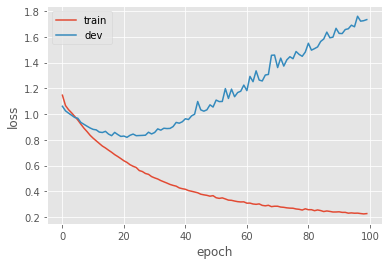

In [ ]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'dev'], loc='best')
plt.show()

In [ ]:
prediction = [np.argmax(x) for x in model.predict(dev_x)]
print(classification_report(label_dev, prediction))

              precision    recall  f1-score   support

           0       0.23      0.28      0.25        25
           1       0.46      0.45      0.45       150
           2       0.46      0.34      0.39        77
           3       0.78      0.82      0.79       380

    accuracy                           0.65       632
   macro avg       0.48      0.47      0.47       632
weighted avg       0.64      0.65      0.64       632



In [ ]:
newdf['aspectCategory'] = prediction
def rerelabel(aspn):
    return {0:'service', 1:'food', 2:'anecdotes/miscellaneous',3: 'ambience', 4:'price'}[aspn]

# apply functions & convert to np.array
newdf['aspectCategory'] = newdf['aspectCategory'].apply(rerelabel)

In [ ]:
# relabel: scheme 2 (only 3 category)
def relabelse(aspn):
    return {'conflict':0, 'negative':1, 'neutral':2,'positive':3}[aspn]

# apply functions & convert to np.array
label_train = np.array(train['polarity'].apply(relabelse).tolist())
label_dev = np.array(dev['polarity'].apply(relabelse).tolist())

# label : one-hot vector
train_y = to_categorical(label_train, num_classes=4)
dev_y = to_categorical(label_dev, num_classes=4)
# instantiation
model = Sequential()

# add embedding layer
model.add(Embedding(input_dim=vocab_size+1,
                    input_length=max_len,
                    output_dim=vector_dim, 
                    weights=[embedding_matrix], 
                    mask_zero=False,
                    trainable=True))

# average
model.add(GlobalAveragePooling1D())

# add hidden layer
model.add(Dense(100, activation='relu'))
# add output layer
model.add(Dense(4, activation='softmax'))

# compile model
model.compile(optimizer="rmsprop", loss="categorical_crossentropy", metrics=["accuracy"])

model.summary()
history = model.fit(train_x, train_y, batch_size=128, epochs=100, validation_data=(dev_x, dev_y))

Model: "sequential_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_6 (Embedding)      (None, 50, 300)           321300    
_________________________________________________________________
global_average_pooling1d_6 ( (None, 300)               0         
_________________________________________________________________
dense_14 (Dense)             (None, 100)               30100     
_________________________________________________________________
dense_15 (Dense)             (None, 4)                 404       
Total params: 351,804
Trainable params: 351,804
Non-trainable params: 0
_________________________________________________________________
Train on 2524 samples, validate on 632 samples
Epoch 1/100
2524/2524 [==============================] - 1s 383us/step - loss: 1.1464 - acc: 0.5713 - val_loss: 1.0603 - val_acc: 0.6013
Epoch 2/100
2524/2524 [==============================] - 0s 14

In [ ]:
newdf['polarity'] = prediction
def rerelabel(aspn):
    return {0:'conflict',1: 'negative',2: 'neutral',3:'positive'}[aspn]

# apply functions & convert to np.array
newdf['polarity'] = newdf['polarity'].apply(rerelabel)

In [ ]:
# export to csv
newdf.to_csv('pred.csv', index=None)

In [ ]:
# evaluate "lab4_train.csv" ไม่ต้องเปลี่ยน
!python3 evaluate.py lab4_train.csv pred.csv

=== CLASSIFICATION : ASPECT ===
                class name  precision  recall  F1-score support
0                     food      0.855   0.724     0.784     203
1                    price      0.933   0.233     0.373      60
2                  service      0.746   0.510     0.606     104
3                 ambience      0.771   0.521     0.622      71
4  anecdotes/miscellaneous      0.785   0.773     0.779     194
5                MACRO AVG      0.818   0.552     0.633     632
6                MICRO AVG      0.807   0.634     0.710     632 

=== CLASSIFICATION : SENTIMENT ===
  class name  precision  recall  F1-score support
0   positive      0.784   0.794     0.789     306
1   negative      0.450   0.432     0.441     125
2    neutral      0.542   0.351     0.426      74
3   conflict      0.316   0.250     0.279      24
4  MACRO AVG      0.523   0.457     0.484     529
5  MICRO AVG      0.662   0.622     0.641     529 

=== CLASSIFICATION : OVERALL ===
              precision  recall  F